### Colorizer

In [308]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 25 11:53:02 2022

@author: LuTimothy
"""

# -*- coding: utf-8 -*-
"""
Created on Thu Oct 20 12:24:56 2022

@author: Timothy Lu
"""
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
# For our model
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# For utilities
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
from sys import platform
from itertools import combinations

# For color conversions
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

import torchvision.transforms as T

import matplotlib.pyplot as plt


#CNN resource: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
if platform == 'darwin':
    slash = '/'
else: 
    slash = '\\'


In [314]:
# loads L, a, b images
# returns a 4-d numpy array: numImages x numChannels x Height x Width
def load(folder):
    # find the largest number file to index (do not worry about how these next few lines work)
    files = glob.glob(folder + "*L.jpg")
    for i, f in enumerate(files):
        f = f[f.rfind('/')+1:]
        files[i] = f[0:f.rfind('.')-1]
    maxFileNum = max([int(f) for f in files])
    
    # for each file index (e.g. ['0L.jpg', '0a.jpg', '0b.jpg'])
    data = []
    for i in range(0, maxFileNum):
        # grab files in order 'L', 'a', 'b'
        files = sorted(glob.glob(folder + str(i) + "?.jpg"))

        # append each file
        imageGroup = []
        for f in files:
            image = cv2.imread(f)

            # only take one channel (all the channels here are the same)
            imageGroup.append(image[:, :, 0])
        
        # group each 3 into a list of numpy arrays
        data.append(np.asarray(imageGroup))
        
    # convert list to numpy array
    data = np.asarray(data)
        
    return data


def group(data, album_length):
    #group into chunks of three because of three sets of images in LAB color space
    for i in range (0, album_length, 3):
        yield image_data[i:i+3]
  

def make_numpy(image):
    image = np.swapaxes(image, 0, 1)
    image = np.swapaxes(image, 1, 2)
    return image


class imageDataset(Dataset):
    def __init__(self,  l_color_space, ab_color_space,):
        a = (ab_color_space[:, 0, :, :])
        b = (ab_color_space[:, 1, :, :])
        l = (l_color_space)
        
        #it seems that I will have to use permute 
        #to get from numpy image representation
        #to torch tensor image 
        
        self.a = torch.Tensor(a).unsqueeze(1).numpy()
        self.b = torch.Tensor(b).unsqueeze(1).numpy()
        self.l = torch.Tensor(l).unsqueeze(1).numpy()
        self.indices = len(l)
        
    def __len__(self):
        return self.indices
      
    
    def __getitem__(self, index):
        return self.l[index], self.a[index], self.b[index]

In [315]:
home_dir = os.getcwd() 
#change this parameter depending on which album you want
target_album = 'LAB_TEST_FACES'

image_data = load(home_dir + slash + target_album + slash)

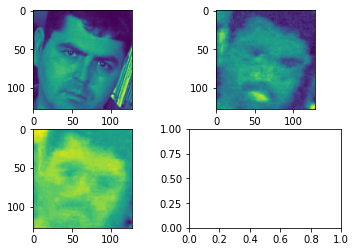

In [316]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_data[0, 0, :, :])
axarr[0,1].imshow(image_data[0, 1, :, :])
axarr[1,0].imshow(image_data[0, 2, :, :])

In [317]:
#prepare grouped data for training and test
train_images, test_images = train_test_split(image_data, test_size = 0.3)

# separate training and testing data into X and y
X_train = train_images[:, 0, :, :]
y_train = train_images[:, 1:3, :, :]

X_test = test_images[:, 0, :, :]
y_test = test_images[:, 1:3, :, :]

#prepare datasets for images
train_dataset = imageDataset(X_train, y_train)
test_dataset = imageDataset(X_test, y_test)

#prepare dataloaders for batch training
#create datasets
batch_size = 10
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size)


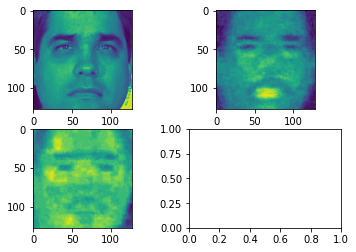

In [318]:
for i, batch in enumerate(train_loader):
    if i==4:
        thing = batch
        break
        
l = thing[0][ind, 0, :, :]
a = thing[1][ind, 0, :, :]
b = thing[2][ind, 0, :, :]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(l)
axarr[0,1].imshow(a)
axarr[1,0].imshow(b)

In [421]:
      
class colorizer(nn.Module):
    def __init__(self, input_size=1, output_size=2):
        super(colorizer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        #128x128
        out1 = 6
        self.downsamp1 = nn.Sequential(
             nn.Conv2d(self.input_size, out1, kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
#              nn.AvgPool2d(kernel_size = (1,1), stride = 1),
             )
        self.batchNorm1 = nn.Sequential(nn.BatchNorm2d(out1))
        
        #64x64
        out2 = 12
        self.downsamp2 = nn.Sequential(
             nn.Conv2d(6, out2, kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
#              nn.AvgPool2d(kernel_size = (1,1), stride = 1),
             )
        self.batchNorm2 = nn.Sequential(nn.BatchNorm2d(out2))
        
        #32x32
        out3 = 24
        self.downsamp3 = nn.Sequential(
             nn.Conv2d(12, out3, kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
#              nn.AvgPool2d(kernel_size = (1,1), stride = 1),
             )
        self.batchNorm3 = nn.Sequential(nn.BatchNorm2d(out3))
        
        #16x16
        out4 = 48
        self.downsamp4 = nn.Sequential(
             nn.Conv2d(24, out4, kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
#              nn.AvgPool2d(kernel_size = (1,1), stride = 1),
             )
        self.batchNorm4 = nn.Sequential(nn.BatchNorm2d(out4))
        
        #8x8
        out5 = 96
        self.downsamp5 = nn.Sequential(
             nn.Conv2d(48, out5, kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
#              nn.AvgPool2d(kernel_size = (1,1), stride = 1),
             )
        self.batchNorm5 = nn.Sequential(nn.BatchNorm2d(out5))
        
        #begin upsampling here
        #using convolution transpose
        #8x8
        self.upsamp1 = nn.Sequential(        
             nn.ConvTranspose2d(out5, 48, kernel_size = 2, stride = 2),
             )
        
        #16x16
        self.upsamp2 = nn.Sequential(         
             nn.ConvTranspose2d(48, 24, kernel_size = 2, stride = 2),         
             )
        
        #32x32
        self.upsamp3 = nn.Sequential(
            nn.ConvTranspose2d(24, 12, kernel_size = 2, stride = 2),         
            )
        
        #64x64
        self.upsamp4 = nn.Sequential(
            nn.ConvTranspose2d(12, 6, kernel_size = 2, stride = 2),         
            )
        
         #128x128
         #keep at 6 channels
        self.upsamp5 = nn.Sequential(
            nn.ConvTranspose2d(6, self.output_size, kernel_size = 2, stride = 2),         
            )
           
       
        
    def forward(self, x, input_size=1, output_size=2):
        #Normalize input first
        out = x
        out = self.downsamp1(out)
        out = self.batchNorm1(out)
        out = self.downsamp2(out)
        out = self.batchNorm2(out)
        out = self.downsamp3(out)
        out = self.batchNorm3(out)
        out = self.downsamp4(out)
        out = self.batchNorm4(out)
        out = self.downsamp5(out)
        out = self.batchNorm5(out)
        out = self.upsamp1(out)
        out = self.upsamp2(out)
        out = self.upsamp3(out)
        out = self.upsamp4(out)
        out = self.upsamp5(out)
        
        return out


In [422]:
# colorer = colorizer()
# batch_l = next(iter(train_loader))[0]
# batch_a = next(iter(train_loader))[1]
# batch_b = next(iter(train_loader))[2]
# output = colorer(batch_l)
# torch.mean(output, dim=[2, 3]).shape

In [ ]:
#run color regressor
Epochs = 40
lr = 0.001
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
colorer = colorizer()
optimizer = torch.optim.Adam(colorer.parameters(), lr)

#training loop: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
train_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    colorer.train()

    running_loss = 0.0

    # for each batch of 10 images
    for i, batch in enumerate(train_loader):

        batch_l = batch[0]
        batch_a = batch[1]
        batch_b = batch[2]

        # get the inputs; data is a list of tensors [chrominance_l_tensor, chrominance_a_tensor, grayscale_b_tensor]
        label_a = batch_a
        label_b = batch_b
        input_l = batch_l

        #need to get the mean of labels across all dimensions
        mean_a = torch.mean(label_a, dim = [2, 3])
        mean_b = torch.mean(label_b, dim = [2, 3])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = colorer(input_l, input_size=1, output_size=2)
#         labels = torch.cat([mean_a, mean_b], dim=1).unsqueeze(0)
#         mean_outputs = torch.mean(outputs, dim=[2, 3]).unsqueeze(0)
        labels = torch.cat([label_a, label_b], dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()


    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format( epoch+1, Epochs, loss))



print('Finished Training')  


Epoch 1 of 40, Train Loss: 19823.754
Epoch 2 of 40, Train Loss: 3265.160
Epoch 3 of 40, Train Loss: 177.482
Epoch 4 of 40, Train Loss: 68.836
Epoch 5 of 40, Train Loss: 58.762
Epoch 6 of 40, Train Loss: 55.011
Epoch 7 of 40, Train Loss: 52.490
Epoch 8 of 40, Train Loss: 50.479
Epoch 9 of 40, Train Loss: 49.481
Epoch 10 of 40, Train Loss: 48.706
Epoch 11 of 40, Train Loss: 47.866
Epoch 12 of 40, Train Loss: 48.132
Epoch 13 of 40, Train Loss: 47.398
Epoch 14 of 40, Train Loss: 47.072
Epoch 15 of 40, Train Loss: 47.252
Epoch 16 of 40, Train Loss: 48.359
Epoch 17 of 40, Train Loss: 47.759
Epoch 18 of 40, Train Loss: 48.067
Epoch 19 of 40, Train Loss: 46.381
Epoch 20 of 40, Train Loss: 48.318
Epoch 21 of 40, Train Loss: 46.314
Epoch 22 of 40, Train Loss: 46.697


In [ ]:
f, axarr = plt.subplots(3, 2)
axarr[0,0].imshow(outputs[0][0].detach().numpy())
axarr[0,1].imshow(label_a[0][0])
axarr[1,0].imshow(outputs[0][1].detach().numpy())
axarr[1,1].imshow(label_b[0][0])
axarr[2,0].imshow(input_l[0][0])

In [ ]:
plt.plot(range(0, Epochs), train_loss)

In [ ]:
# #call the regressor on one set of images in the X_train dataset
# color = colorizer()
# #run forward pass on one grayscale image
# sample_a, sample_b, sample_grayscale = train_dataset[0]

# prediction = color(sample_grayscale)
# prediction_a = prediction[0:3]
# prediction_b = prediction[3:]

# #swapaxes and convert to numpy array
# prediction_a = prediction_a.detach().numpy().astype(np.uint8)
# prediction_b = prediction_b.detach().numpy().astype(np.uint8)

# prediction_a = make_numpy(prediction_a)
# prediction_b = make_numpy(prediction_b)
# merged_prediction = cv2.merge([sample_grayscale[:,:,0], prediction_a[:,:,0], prediction_b[:,:,0]])

# #plot the target
# plt.imshow(target)
# #plot the reconstruction
# plt.imsmhow(merged_prediction)

In [ ]:
# lab = np.asarray([image_data[0, 0, :, :], image_data[0, 1, :, :], image_data[0, 2, :, :]])
# lab = torch.Tensor(lab).permute(1, 2, 0)
# lab = lab.numpy().astype(int)
# lab.shape
# from skimage import io, color
# rgb = color.lab2rgb(lab)
# plt.imshow(lab)

### Augment and Preprocessing

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 17 11:13:04 2022

@author: LuTimothy
"""

import cv2
import os
import glob
import numpy as np
import torch
from sys import platform

import torch
import torchvision.transforms as T
from PIL import Image

from matplotlib import pyplot as plt

torch.set_default_tensor_type(torch.FloatTensor)


path = os.getcwd() 

if platform == 'darwin':
    slash = '/'
else: 
    slash = '\\'



In [2]:
def load(folder):
    files = glob.glob(folder)
    data =[]
    for f in files:
        image = cv2.imread(f)
        data.append(image)
    return data
    #need to change height and width to 128
    #also need to get randindexes?
    


def resize(album):
    for index, photo in enumerate(album):
        #have to get the photo from numpy array to pillow object
        transform_pil = T.ToPILImage()
        photo = transform_pil(photo)
    
        transform_size = T.Resize((128,128))
        img = transform_size(photo)
        album[index] = img
          #album[index] = image
    return album
    #album = np.stack(album,axis = 3)
    

        

def convert(album):
    #convert everything in the lists to tensors
    #then stack list of tensors
    #to get 4d tensor
     for index, img in enumerate(album):
         make_tensor = T.ToTensor()
         img = make_tensor(img)
         album[index] = img
         if(img) == None:
             print('there is none object')
    #should convert list of tensors to 4d tensor
     album = torch.stack(album)
     
     return album  
     

        
def ShuffleData(album):
    # get random permutation of indices
    indices = torch.randperm(album.shape[0])
    
    # return album in order of random permutation of indices
    return album[indices]
    

    
def AugmentData(album, xTimesSamples=10, keepOriginal=True, min_percent_crop=0.5):
    # using OpenCV
    # Flip, Random Crop, RGB Scaling
    
    # create empty tensor of 10x more samples w/ same dimensions
    album_new = torch.zeros([album.shape[0]*xTimesSamples] + [album.shape[i] for i in range(1,len(album.shape))])
    
    # if specified to keep the original data
    if keepOriginal:
        album_new[0:album.shape[0]] = album[np.random.permutation(album.shape[0])]
        count = album.shape[0]
    else:
        count = 0
        
    # until sample is filled in
    while count < album_new.shape[0]:
        
        # create random permutation of all the data indices
        indices = np.random.permutation(album.shape[0])
    
        # for each image in the above permutation
        for ind in indices:
            # get image and augment image
            image = album[ind]
            image = AugmentImage(image, min_percent_crop=min_percent_crop)
            
            # store augmented image in tensor
            album_new[count] = image

            # increase count
            count = count + 1
            
    return album_new
            
            
            
def AugmentImage(image, min_percent_crop=0.5):
    
    # convert image to numpy array
    image = image.numpy()
    
    # number of augmentation strategies
    numAugStrat = 3
    
    # get a random permutation of 0 to 2 (index for augmentation technique)
    augTechs = np.random.permutation(numAugStrat)

    # random number of augmentations to use
    numAugTechs = np.random.randint(1, numAugStrat+1)

    # for each sample, perform random augmentation techniques
    augTechs = augTechs[0:numAugTechs]
    for augNum in augTechs:
        # horizontally flip image
        if augNum == 0:
            image = cv2.flip(image, 1)

        # crop and resize image
        if augNum == 1:
            crop_dim = np.random.randint(int(min_percent_crop*image.shape[-2]), image.shape[-2])
            image = RandomCrop(image, crop_dim, crop_dim)

        # rgb scaling for image
        if augNum == 2:
            scale = np.random.uniform(low=0.6, high=1)
            image = image * scale
    
    # convert image back to tensor and return result
    image = torch.Tensor(image)
                    
    return image
                    
    
    
    
# First 7 lines from RandomCrop from: https://stackoverflow.com/questions/42263020/opencv-trying-to-get-random-portion-of-image 
def RandomCrop(image, crop_height, crop_width):
    # get size of 
    max_x = image.shape[-1] - crop_width
    max_y = image.shape[-2] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)
    
    crop = np.zeros([image.shape[-3], crop_height, crop_width])
    cropResize = np.zeros([image.shape[-3], image.shape[-2], image.shape[-1]])
    for i in range(0, image.shape[-3]):
        crop[i] = image[i][y: y + crop_height, x: x + crop_width]
        cropResize[i] = cv2.resize(crop[i], (image.shape[-2], image.shape[-1]))

    return cropResize
        

In [3]:
face_path = path + slash + 'face_images'
originals_path = path + slash + 'ColorfulOriginal'
grayscale_path = path + slash + 'gray'

# for name in glob.glob(face_path + slash + '*', recursive = True):
#     print(name)    


album_faces = load(face_path + slash +'*.jpg')
# album_colors = load(originals_path + slash + '**' + slash +'*.jpg')
# album_gray = load(grayscale_path + slash + '**' + slash +'*.jpg')

#note album_faces is already size 128x128 does not need to be resized
album_faces = convert(album_faces)

# album_colors = resize(album_colors)
# album_colors = convert(album_colors)

# album_gray =resize(album_gray)
# album_gray = convert(album_gray)

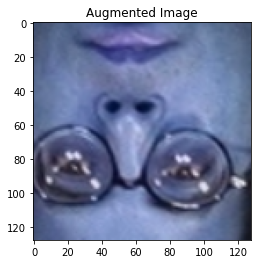

In [4]:
plt.imshow(album_faces[0].permute(-2, -1, -3));
plt.title("Original Image");

plt.imshow(AugmentImage(album_faces[0], min_percent_crop=0.75).permute(-2, -1, -3));
plt.title("Augmented Image");

album_faces_aug = ShuffleData(AugmentData(album_faces, xTimesSamples=10, keepOriginal=True, min_percent_crop=0.75))
plt.imshow(album_faces_aug[125].permute(-2, -1, -3))

In [11]:
from matplotlib.pyplot import title


def ImageToLAB(image):
#     new_album = torch.zeros([i for i in album.shape])
#     for i, im in enumerate(album):
#         new_album[i] = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    new_image = cv2.cvtColor(image.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2LAB)
            
    return new_image


# album_faces_aug_LAB = ImageToLAB(album_faces_aug[0])
# print(image.permute(-2, -1, -3))

imageLAB = ImageToLAB(album_faces_aug[0])
norm_imageLAB = np.zeros_like(imageLAB)
norm_imageLAB = cv2.normalize(imageLAB,norm_imageLAB,0,1,cv2.NORM_MINMAX)
L,a,b=cv2.split(norm_imageLAB)

cv2.imshow('image', norm_imageLAB, )
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow("LChannel", L) #album_faces[0].permute(1, 2, 0).numpy())
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('aChannel', a)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('bChannel', b)
cv2.waitKey(0)
cv2.destroyAllWindows()

# plt.figure()
# plt.title('Image')
# plt.imshow(norm_imageLAB)
# plt.show()
# plt.title('LChannel')
# plt.imshow(L)
# plt.show()
# plt.title('aChannel')
# plt.imshow(a)
# plt.show()
# plt.title('bChannel')
# plt.imshow(b)
# plt.show()